# *Saccharomyces cerevisiae* Genetic Interactions: Protein Complexes

<u>Goal:</u> identify protein complexes and functional net clusters that are enriched in genetic interactions (between and within).

---

In [1]:
import collections

In [2]:
import configparser

In [3]:
import math

In [4]:
import matplotlib

In [5]:
matplotlib.use('Agg')

In [6]:
%matplotlib inline

In [7]:
import matplotlib.pyplot as plt

In [8]:
import os

In [9]:
import networkx as nx

In [10]:
import numpy as np

In [11]:
import pandas as pd

--- 

## Cluster interaction density

**2015 November 3-7, 9**

To identify significant enrichments, many random genetic interaction networks will need to be generated. First generate the actual interaction network, represented by the adjacency matrix. The genes on the rows/columns will be assembled from protein complexes and functional net, along with the genetic interactions. Refer to the script *geneintactmatrix.py*. 

This process will need to be performed on other organisms. The protein complex files all have different formats. For ease in coding, pre-process these protein complex files into a common 2 column format:

protein complex name/ID | gene

Refer to the script *proteincomplexformat.py* in *DataProcessScripts/*.

In [2]:
os.chdir(os.path.join('..', '..', 'DataProcessScripts'))

In [3]:
%run proteincomplexformat

<u>Notes:</u> *S. cerevisiae* has genetic interactions, functional net and protein complexes all available in official gene symbol. 

Downloaded BIOGRID version 3.4.130. For the *S. cerevisiae* file, create a file *BIOGRID-3.4.130-yeast-post2006.txt* that only includes interactions from 2007 onward (see code above for doing this). 

The matrix of genetic interactions (of any type) evidently has 6404 genes. To check this number, use NCBI Gene:

In [12]:
officialSymbols = set()
os.chdir('/work/jyoung/DataDownload/NCBI_Gene/')
fid = open('Saccharomyces_cerevisiae.gene_info')
header = fid.readline()
for line in fid:
    officialSymbols.add(line.split('\t')[2])
fid.close()

In [13]:
len(officialSymbols)

6350

In Python interactive mode, test which of the gene symbols in the interaction matrix are NOT found in the set of official symbols from NCBI. Unfortunately, there are 716 such offenders. For example: RBF64 (from FunctionalNet, since changed to TMA64); YOR051C; CDK2 (human gene from BIOGRID); INA17, INA22 and ATG38 (both of which are new and not included in official symbols set); gsf2 (*S. pombe* sequence orphan from BIOGRID). Ignore the discrepancy and move on. Perhaps functional net, BIOGRID or the protein complexes use the systematic name, aliases or homologs in some instances. 

Next, try randomly choosing entries from the adjacency matrix and check that the interaction/non-interaction is correct: 

    whereones = np.where(adjMat == 1)
    randpick = random.randrange(whereones[0].size)
    i, j = whereones[0][randpick], whereones[1][randpick]
    idx2gene[i], idx2gene[j]

This was done 5 times and all of them check out. Zero entries in the matrix where also checked. 

**2015 November 10**

How long does it take, given an adjacency matrix, to generate a random graph with the same degree sequence and write it out as an adjacency matrix? Using the negative genetic adjacency matrix with the following code,

    def rand_graph_mat(nodelist_, degseq):
        randG = nx.random_degree_sequence_graph(degseq)
        mapping = {i: j for i,j in zip(randG.nodes(), sorted(nodelist_, key=lambda f: random.random()))}
        nx.relabel_nodes(randG, mapping, copy=False)
        randM = nx.to_scipy_sparse_matrix(randG, nodelist=nodelist_)
    
    %timeit rand_graph_mat(Gnodes, degseq)

it turns out there is a big problem. Not only did the *%timeit* statement take over 12 hours to run, but it "failed to generate random graph in 10 tries." 

From a discussion in meeting, the method all along is really quite simple: shuffle the node labels! Even the approach of crossing edges is too complicated. Just shuffle the node labels. 

**2015 November 13**

Have been debating whether node labels actually need to be shuffled - would it be equivalent, for each pair of protein complexes, to randomly choose 2 sets of nodes, each of the same size as the complexes?

As it shouldn't be too hard to shuffle node labels, both approaches could be tried. The time that it takes for the shuffling:

In [2]:
d = dict(zip(range(20000), range(1, 20001)))

In [3]:
def np_random_shuffle():
    keys = list(d.keys())
    np.random.shuffle(keys)
    dshuf = dict(zip(keys, d.values()))

In [4]:
%timeit np_random_shuffle()

1000 loops, best of 3: 1.78 ms per loop


**2015 November 14-15**

Added */work/jyoung/DataProcessScripts/* to PYTHONPATH. Created script *genesets.py* in *DataProcessScripts/* with function *process_gene_set_file()* borrowed from *find_nsclc_vulner.py*. Modifying *clust_intact.py* to take clusters as protein complexes. 

Started job @ 17:47 with *clust_intact.py* on *S. cerevisiae* and negative genetic interactions. It actually looks as if these jobs will have very long execution times. A couple hundred protein complexes yields on the order of 10<sup>4</sup> pairs and with 10<sup>4</sup> randomizations, there are 10<sup>8</sup> calculations. 

**2015 November 16-17**

Writing *clustintactparallel.py* to parallelize across shared-memory architectures. 

Also the *S. cerevisiae* protein complex file *Sc_prot_cmplx_Hart2007.htm* contains complexes that have only one gene. Modified *proteincomplexformat.py* to disregard such "complexes."

As of 20:02 of the 17<sup>th</sup>, the job is still running (>50 hr. runtime so far); it is manually killed to make way for *S. pombe* parallel runs. 

**2015 November 24**

Added code to *clust_intact.py* for multiple hypothesis correction and print statements to report values such as background binomial probability. 

There are 390 protein complexes, which gives 75855 protein complex pairs to examine. Results of running *clust_intact.py* (# significant is for between-complex pair interactions):

| Interaction type             | # significant (5% FDR, Benjamini-Hochberg) | Background probability |
|------------------------------|:------------------------------------------:|:----------------------:|
| Dosage Growth Defect         | 4                                          | 0.00258                |
| Dosage Lethality             | 1                                          | 0.00257                |
| Dosage Rescue                | 1                                          | 0.00170                |
| Negative Genetic             | 1074                                       | 0.00776                |
| Positive Genetic             | 190                                        | 0.00284                |
| Phenotypic Enhancement       | 29                                         | 0.00202                |
| Phenotypic Suppression       | 13                                         | 0.00250                |
| Synthetic Haploinsufficiency | 0                                          | 0.00754                |
| Synthetic Lethality          | 98                                         | 0.00161                |
| Synthetic Growth Defect      | 355                                        | 0.00216                |
| Synthetic Rescue             | 49                                         | 0.00162                |

**2015 November 25**

Modified *clust_intact.py* to count number of interactions using a set of genetically interacting pairs instead of summations in the adjacency matrix, which may overcount. Also created *biogrid.py* which contains a function to return a set of interacting pairs and *get_biogrid_genes()* (moved from *geneintactmatrix.py*). 

Revised results above - background probability only changed slightly for a few (in the last significant figure) and number of significant pairs remained the same. 

Added function *within_interact_binom()* to *clust_intact.py* to calculate within-cluster interactions.

**2015 November 28**

Ran *clust_intact.py* to compute within-complex interactions statistics:

| Interaction type             | # significant (5% Benjamini-Hochberg) |
|------------------------------|---------------------------------------|
| Dosage Growth Defect         | 1  |
| Dosage Lethality             | 0  |
| Dosage Rescue                | 22 |
| Negative Genetic             | 37 |
| Positive Genetic             | 39 |
| Phenotypic Enhancement       | 25 |
| Phenotypic Suppression       | 22 |
| Synthetic Haploinsufficiency | 0  |
| Synthetic Lethality          | 26 |
| Synthetic Growth Defect      | 40 |
| Synthetic Rescue             | 7  |

Used *clustintactvis* to examine networks for significant between- and within-cluster interactions. 

**2016 January 6, 8, 11-12**

Started modifying *clust_intact.py* to investigate effects of genetic interaction sparsity. Specifically, an increasing portion of the known genetic interactions are withheld and the number of significant complex interactions are calculated. The aim is to produce a plot of number of significant complexes vs. % genetic interactions withheld. Results will be collected in the <s>Google Sheet *Genetic Interaction Sparsity*</s> Microsoft Excel spreadsheet *Genetic Interaction Sparsity.xlsx*. 

**2016 February 15**

Perhaps the way to go about withholding genetic interactions to find a cutoff point beyond which no significant between- or within-cluster interactions are found is to withhold based on node degree. The degree distributions according to each type of genetic interaction are plotted below:

In [7]:
def get_degree_histogram(interactType, geneIDread, biogridFilename):
    """geneIDread should be 'Entrez Gene', 'Systematic Name', or 'Official Symbol'"""
    rootDir = os.path.abspath(os.sep)
    biogridDir = os.path.join(rootDir, 'work', 'jyoung', 'DataDownload', 'BIOGRID', 
                              'BIOGRID-ORGANISM-3.4.130.tab2', '')
    biogridfile = open(biogridDir + biogridFilename)
    header = biogridfile.readline().rstrip().split('\t')
    interactTypeCol = header.index('Experimental System')
    geneCol = header.index(geneIDread + ' Interactor A')
    G = nx.Graph()
    for line in biogridfile:
        tokens = line.rstrip().split('\t')
        if tokens[interactTypeCol] == interactType:
            G.add_edge(tokens[geneCol], tokens[geneCol+1])
    biogridfile.close()
    
    return nx.degree_histogram(G)

In [8]:
biogridFilename = 'BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.4.130.tab2.txt'
geneIDread = 'Official Symbol'
degHistDict = dict()
geneInteractTypes = ['Negative Genetic', 'Positive Genetic',
                    'Phenotypic Enhancement', 'Phenotypic Suppression',
                    'Synthetic Growth Defect', 'Synthetic Lethality']
for gitype in geneInteractTypes:
    degHistDict[gitype] = get_degree_histogram(gitype, geneIDread, biogridFilename)

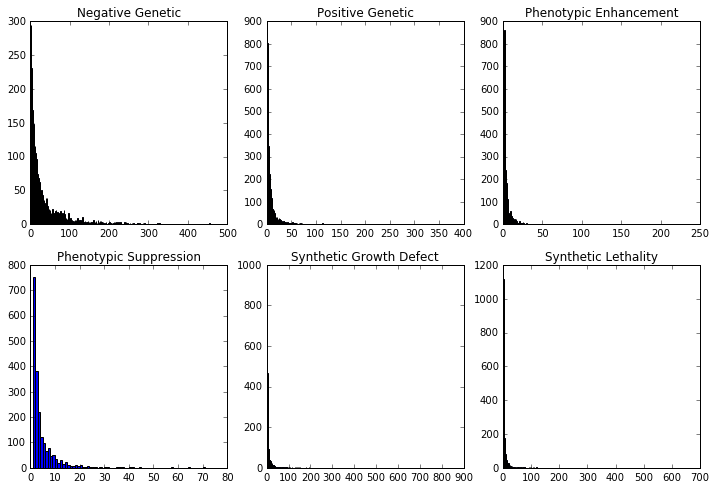

In [11]:
fig = plt.figure(figsize=(12,8))
for k in range(len(geneInteractTypes)):
    plt.subplot(2,3,k+1)
    plt.bar(range( len(degHistDict[geneInteractTypes[k]]) ), 
            degHistDict[geneInteractTypes[k]], width=1.0)
    plt.title(geneInteractTypes[k])
plt.show()

**2016 February 16-17**

Changes were made to *clust_intact.py* by adding a function to withhold genetic interactions based on a gene's vertex degree in the interaction network. Results of the withholding process are listed here:

In [22]:
withholdNG = pd.DataFrame()  # Negative Genetic

# removing all nodes with degree greater than the max degree set
#withholdNG['max degree'] = [500, 400, 300, 200, 100, 50, 10]
#withholdNG['density'] = [7.76e-03, 7.54e-03, 7.04e-03, 5.44e-03, 2.91e-03, 1.17e-03, 7.06e-05]
#withholdNG['avg degree'] = [36.74, 35.68, 33.19, 25.11, 12.49, 4.34, 0.13]
#withholdNG['pct withheld'] = [0.00, 3.02, 10.13, 33.37, 69.15, 90.77, 99.86]
#withholdNG['num complex pairs'] = [1074, 1000, 776, 261, 12, 2, 0]

# removing all nodes with degree less than the min degree set
withholdNG['min degree'] = [0, 5, 10, 50, 100, 200, 300]
withholdNG['density'] = [7.76e-03, 1.18e-02, 1.76e-02, 7.41e-02, 1.69e-01, 3.73e-01, 5.48e-01]
withholdNG['avg degree'] = [36.74, 44.77, 52.91, 78.06, 74.29, 44.73, 13.69]
withholdNG['pct withheld'] = [0.00, 2.52, 8.66, 52.69, 81.18, 96.89, 99.80]
withholdNG['num complex pairs'] = [1074, 1069, 1050, 679, 290, 61, 1]

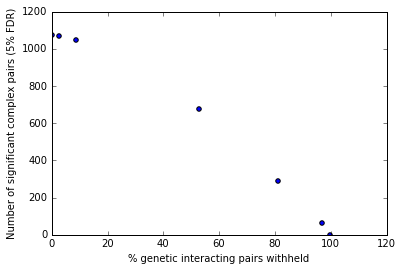

In [23]:
plt.scatter(withholdNG['pct withheld'], withholdNG['num complex pairs'])
plt.xlabel('% genetic interacting pairs withheld')
plt.ylabel('Number of significant complex pairs (5% FDR)')
plt.gca().set_xlim(left=0)
plt.gca().set_ylim(bottom=0)
plt.show()

<u>Initial results for negative genetic</u>  
When withholding first the largest degree nodes (e.g. moving from the right side in the degree plots above), there is an immediate decline followed by a leveling-off in significant complex pairs. This trend holds whether it is the density, mean degree or percent withheld plotted on the x-axis. 

On the other hand, when withholding first the small degree nodes (e.g. moving from the left side in the degree plots above), there is a slight decrease followed by a steady drop-off in significant complex pairs. Oddly in this case, the density and average degree are neither monotonically increasing or decreasing. 

**2016 February 20, 23-29, March 1**

Revising *clust_intact.py* to add functions for assessing cluster interaction through a permutation method instead of a binomial model. As seen above, the binomial model may be sensitive to genetic interaction hubs. 

To facilitate multiple runs of *clust_intact.py* especially when given a range of percent of interactions to withhold, the script was modified to accept command-line arguments with the aim of using GNU parallel. Therefore, an input comma-separated text file is now required, with each line formatted like so:

> cerevisiae,Negative Genetic,binomial,500

Note that the last entry could either be min/max degree or percent of pairs to withhold. At the moment, code must be (un)commented to choose whether to withhold uniformly at random or based on genetic interaction degree. The bash command to use GNU parallel is

    echo '[Negative Genetic]' > unirand1.txt
    parallel -k -a clust_intact_input.txt --colsep ',' python clust_intact.py {1} {2} {3} {4} >> unirand1.txt
    echo '' >> unirand1.txt

In addition, only within-complex interactions are being considered at this point, since the idea of evaluating protein complex interactions was motivated by evolutionary conservation and it seems somewhat more natural to think of single clusters than cluster pairs being conserved across organisms. 

The version of *clust_intact.py* as it stands is being executed for both <u>binomial</u> and <u>permutation</u> models under the following conditions for within-complex interactions:

1. withholding uniformly @ random
2. removing nodes over a maximum allowed degree
3. removing nodes under a minimum allowed degree

The *configparser* library is being used to read & write the results.

### Binomial Model

Results from the 1<sup>st</sup> condition seem to agree with those obtained earlier that were recorded in the Excel spreadsheet *Genetic Interaction Sparsity.xlsx*. As before, 3 trials were run with output written to *unirand1.txt*, *unirand2.txt*, *unirand3.txt*. Plotting the results:

In [9]:
os.chdir(os.path.join('..', 'results', 'yeastIntactClust', 'WithinComplex'))

In [10]:
def plot_uniform_rand_withhold(basename):
    """INPUT: basename is either 'unirand' or 'permUniRand'"""
    # Organize the results into a dictionary like so:
    # dict[interaction type] = 
    #     [ [trial1 results], [trial2 results], [trial3 results] ]
    intacts2numsig = collections.defaultdict(list)
    config = configparser.ConfigParser()
    for i in range(3):
        config.read('{}{}.txt'.format(basename, i+1))
        for intacts in config.sections():
            intacts2numsig[intacts].append( 
                [int(config[intacts][pct]) for pct in config[intacts]] )

    # Plot the results for each interaction type
    numIntacts = len(intacts2numsig)
    numSubplotRows = math.ceil(numIntacts / 2)
    xaxis = [10*i for i in range(10)]
    fig = plt.figure(figsize=(12.0, numSubplotRows*4.0))
    markers = ['o', '^', '+']
    for k, intacts in enumerate(intacts2numsig):
        plt.subplot(numSubplotRows, 2, k+1)
        for i in range(3):
            plt.scatter(xaxis, intacts2numsig[intacts][i], 
                        marker=markers[i], label='Trial {}'.format(i+1))
        xmin, xmax = plt.xlim()
        plt.xlim(0, xmax)
        ymin, ymax = plt.ylim()
        plt.ylim(0, ymax)
        plt.legend(loc='upper right')
        plt.xlabel('% genetic interactions withheld')
        if k % 2 == 0:
            plt.ylabel('# complexes with enriched interactions')
        plt.title(intacts)
        plt.grid(b=True)
    plt.tight_layout()
    plt.show()

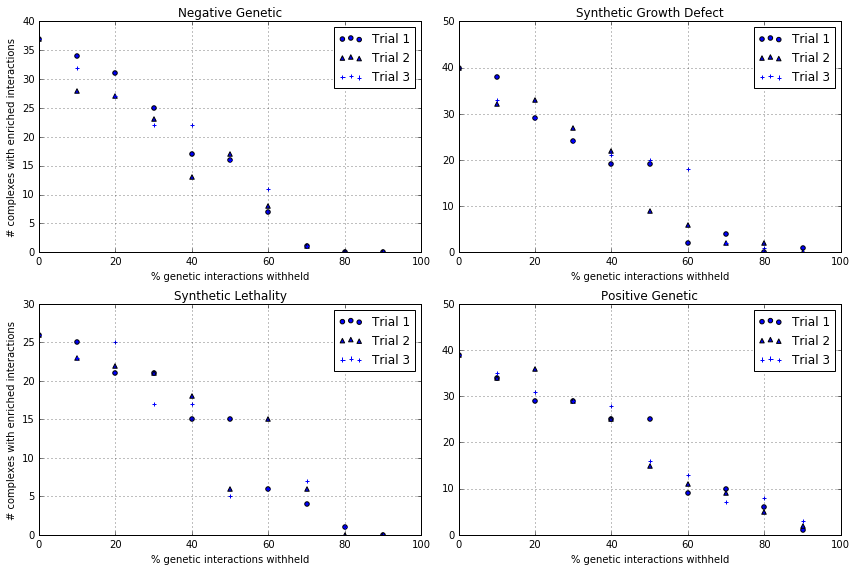

In [17]:
plot_uniform_rand_withhold('unirand')

Next, the results for removing nodes <u>over</u> the following <u>maximum</u> allowed degrees:

+ Negative Genetic: 500, 400, 300, 200, 150, 100, 75, 50, 25, 10
+ Positive Genetic: 400, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10
+ Synthetic Growth Defect: 900, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 5
+ Synthetic Lethality: 700, 100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 5

The results were written to *rmOverMaxDeg.txt*, and duplicate lines were eliminated (since apparently sometimes there was no change in genetic interactions withheld when going from a certain degree cutoff to another):

    awk '!NF || !seen[$0]++' rmOverMaxDeg.txt > tmp && mv tmp rmOverMaxDeg.txt

Plotting the results:

In [18]:
def plot_node_deg_withhold(filename):
    # Organize results into a dictionary with the format
    # dict[interaction type] = [ [pct withheld], [num sig] ]
    intacts2pts = dict()
    config = configparser.ConfigParser()
    config.read(filename)
    for intacts in config.sections():
        intacts2pts[intacts] = [ [float(pct) for pct in config[intacts]], 
                [int(config[intacts][pct]) for pct in config[intacts]] ]

    # Plot results for each interaction type
    numIntacts = len(intacts2pts)
    numSubplotRows = math.ceil(numIntacts / 2)
    fig = plt.figure(figsize=(12.0, numSubplotRows*4.0))
    for k,intacts in enumerate(intacts2pts):
        plt.subplot(numSubplotRows, 2, k+1)
        plt.scatter(intacts2pts[intacts][0], intacts2pts[intacts][1])
        xmin, xmax = plt.xlim()
        plt.xlim(0, xmax)
        ymin, ymax = plt.ylim()
        plt.ylim(0, ymax)
        plt.xlabel('% genetic interactions withheld')
        if k % 2 == 0:
            plt.ylabel('# complexes enriched in interactions')
        plt.title(intacts)
        plt.grid(b=True)
    plt.tight_layout()
    plt.show()

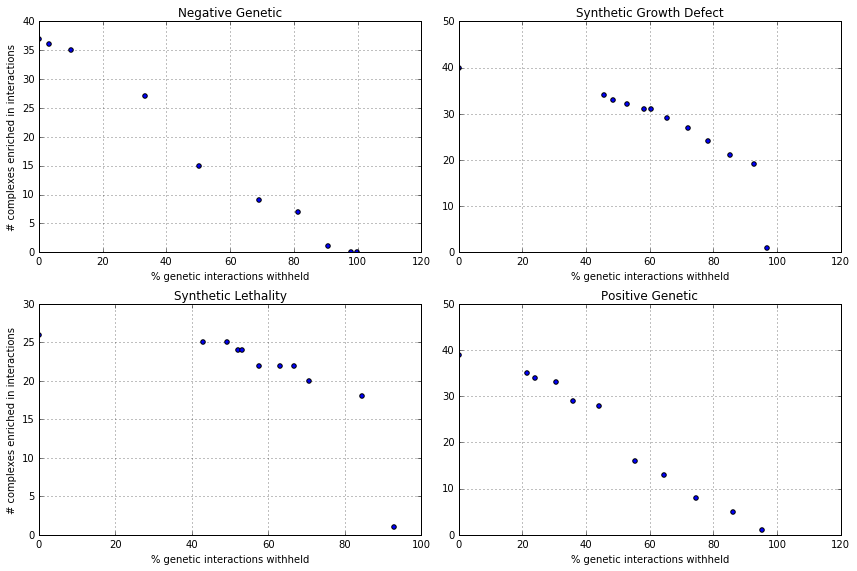

In [19]:
plot_node_deg_withhold('rmOverMaxDeg.txt')

The results for removing nodes <u>under</u> the following <u>minimum</u> allowed degrees:

+ Negative Genetic: 0, 5, 10, 15, 25, 50, 75, 100, 200, 300
+ Postivie Genetic: 0, 5, 10, 15, 20, 25, 50, 75, 100
+ Synthetic Growth Defect: 0, 1, 2, 3, 4, 5, 10, 25, 50, 75, 100, 150
+ Synthetic Lethality: 0, 1, 2, 3, 4, 5, 10, 25, 50, 75, 100

The results were written to *rmUnderMinDeg.txt*; once again duplicate lines were removed. 

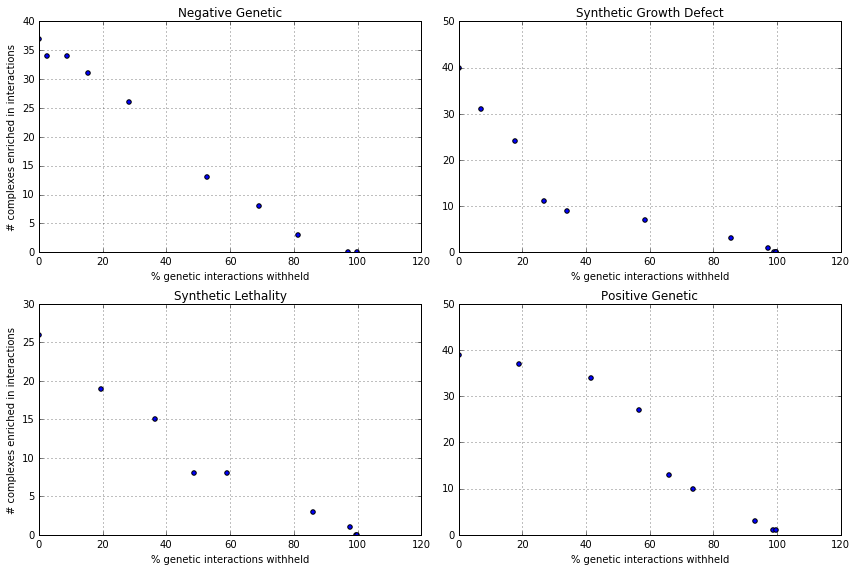

In [20]:
plot_node_deg_withhold('rmUnderMinDeg.txt')

### Permutation method

Achieved version of *clust_intact.py* on 27 February 2016 that includes a fully working version of the permutation method. Further changes were also made to both *clust_intact.py* and *biogrid.py* as a result of the fact that BIOGRID lists some genes as self-interacting. *clust_intact.py* using the permutation method was run on the same cases and parameters as above for the binomial model. Results were written to *permUniRand&lt;1-3&gt;.txt*, *permRmOverMaxDeg.txt*, and *permRmUnderMinDeg.txt*. 

Plotting the results for withholding uniformly @ random:

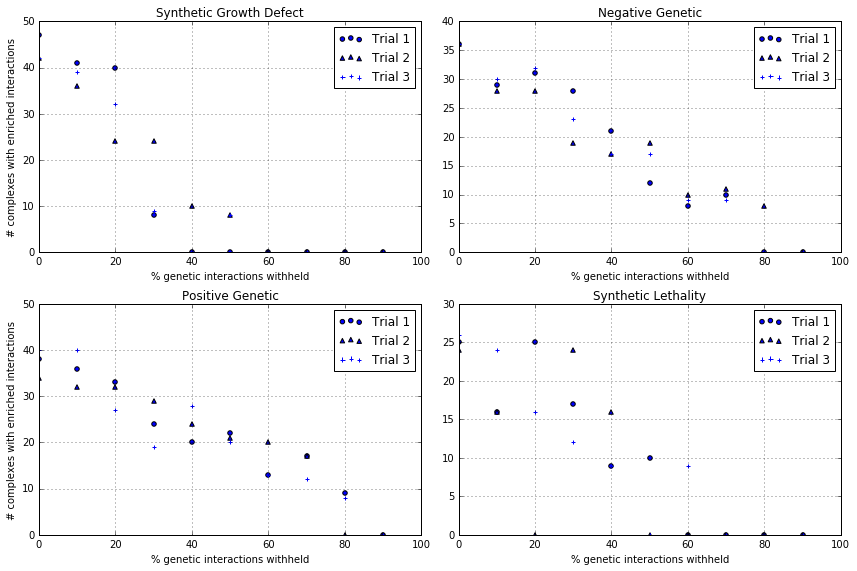

In [11]:
plot_uniform_rand_withhold('permUniRand')

There is quite a lot of variation when withholding uniformly at random. 

As the process of withholding on node degree began, it became clear that there was a problem with using the permutation method. Initially, the permutation method involved construction of an adjacency data frame and shuffling of the row and column labels. The row and column labels included all genes participating in interactions along with those present in all protein complexes. When withholding based on node degree, the results were very odd, as at times withholding more genetic interacting pairs produced more significant within-complex interactions than no withholding. The puzzling results were surmised to be caused by the data frame approach. Therefore, instead of using data frames, graph edge lists were used as had been done for the binomial model. As a side note, this approach yield faster run times than before - times for negative genetic were about the same (12-15 min vs 12-13 min) but there was quite a difference for all other interaction types (12-15 min vs 1-3 min). Unfortunately, the problem seen with using data frames persisted, for example: 

*Synthetic Growth Defect, Synthetic Lethality*  
0.00 &rarr; 39, 0.00 &rarr; 24  
45.68 &rarr; 48, 42.95 &rarr; 17  
48.51 &rarr; 42, 49.25 &rarr; 20  
52.85 &rarr; 41, 52.02 &rarr; 27  
58.08 &rarr; 45, 53.17 &rarr; 20  
60.45 &rarr; 41, 53.17 &rarr; 26  
65.32 &rarr; 42, 57.54 &rarr; 22  
71.86 &rarr; 39, 62.95 &rarr; 24  
78.36 &rarr; 43, 66.72 &rarr; 26  
85.30 &rarr; 45, 70.72 &rarr; 13  
92.70 &rarr; 27, 84.53 &rarr; 24  
96.78 &rarr; 0, 92.75 &rarr; 0

The data above is from withholding nodes over a given maximum degree cutoff (same cutoffs as used above for the binomial model). The 1<sup>st</sup> column under each interaction is the percent of genetic interaction pairs withheld as a result of removing nodes over the maximum degree cutoff. The 2<sup>nd</sup> column is the number of complexes with significant (5% FDR, *q* value) number of interactions within. The odd trend in the 2<sup>nd</sup> is apparent. Moreover, for synthetic lethality, the same percent withheld gave 2 different answers! These puzzling and concerning results were not changed by setting the random seed or using Benjamini-Hochberg in place of *q* value. 